# Итоговый алгоритм подбора оптимального частотного диапазона  

<IPython.core.display.Javascript object>


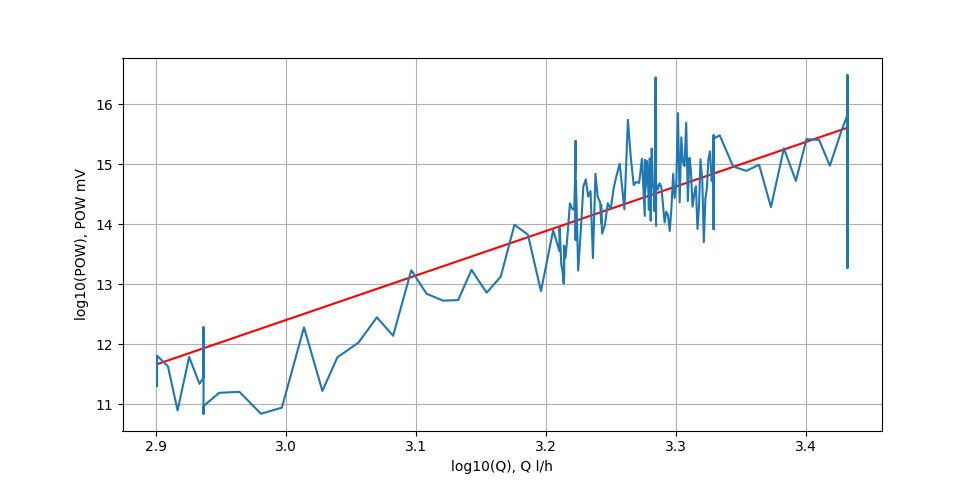

Оптимальный диапазон частот: 1.4 кГц, 
Степень: 7.419 
СКО: 0.7601380121022956 



In [15]:
import lasio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

%matplotlib notebook

'''
Функция return_freq принимает SNL панели в формате .las
И извлекает частоты из описания. Регулярка ТОЛЬКО ДЛЯ LFP, форматы *.***
'''

def return_freq(las_file):
    freq = []
    for i in range(1, 513):
        freq.append(float(re.findall(r'\d\.\d{3}\b', las_snl.curves[i]['descr'])[0]))
    return np.array(freq)

def dBTomV(data):
    return (2**16)*10**(data/10)

def func(x,a, b, c):
    return b*(x**a)+c

def lin_func(x, a, b):
    return a*x+b


'''
В файле QZI.las лежит информация о расходе флюза по всей глубине скважины. 
LFP_FLOWING.las -- SNL панели, полученные в MAXIM

'''

las = lasio.read('LFP_POW_3201.las')
las_qzi = lasio.read('QZI.las')
las_snl = lasio.read('LFP_FLOWING_3402.las')

df = las.df()
df_qzi = las_qzi.df()
df_snl = las_snl.df()
df_snl_T = df_snl.transpose()
freq = return_freq(las)

DEPTH = las.index
POW = np.array(df['POW'])
SPEED = np.array(df_qzi['QZI_SIM-COPY'][2400:3153.1])
DEPTH_SP = np.array(df_qzi[2400:3153.1].index)
Q = df_qzi.loc[DEPTH[:330]]*(-1) ### Расход флюида для глубин DEPTH


'''
spm_bg - профиль СПМ фонового шума
За background возьму СПМ при минимальном расходе (Нуля в данных нет)

'''
spm_bg = df_snl_T[3153.1][:512]

snl_pow = [np.sum(dBTomV((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= 1.4])])[50:]**2) for i in range(376)]

x = np.log10(np.array(Q['QZI_SIM-COPY']))
y = lin_func(x, 7.419, -9.851)
plt.plot(x,y, "red")

plt.plot(np.log10(np.array(Q['QZI_SIM-COPY'])), np.log10(snl_pow[0:330]))
plt.ylabel('log10(POW), POW mV')
plt.xlabel('log10(Q), Q l/h')
plt.grid()
plt.show()

sko = []
power = []

for j in np.arange(0.5, 5, 0.1):
    snl_pow = [np.sum(dBTomV((df_snl_T[DEPTH[i]][:512]-spm_bg)[:len(freq[freq <= j])])[50:]**2) for i in range(376)]
    popt, pcov = curve_fit(lin_func, np.log10(np.array(Q['QZI_SIM-COPY']))[:300], np.log10(snl_pow[:300]))
    sko.append(np.sqrt(np.diag(pcov))[1]-np.sqrt(np.diag(pcov))[0])
    power.append(float("{0:.3f}".format(popt[0])))
    
power = np.array(power)
sko = np.array(sko)
delta_f = np.arange(0.5, 5, 0.1)

i, = np.where((power > 7) & (power < 9))
min_sko = sko[i].min()

print(f'Оптимальный диапазон частот: {delta_f[np.where(sko == min_sko)][0]} кГц, \n' 
      f'Степень: {power[np.where(sko == min_sko)][0]} \n'
      f'СКО: {min_sko} \n')